# Task 1.2 DataPreparation

In [43]:
import math
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sn
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

In [44]:
# load the datasets
df_incidents = pd.read_csv('../datasets_clean/incidents_clean.csv', sep=',', index_col=0)
df_poverty = pd.read_csv('../datasets_clean/poverty_clean.csv', sep=',', index_col=0)
df_elections = pd.read_csv('../datasets_clean/elections_clean.csv', sep=',', index_col=0)

In [45]:
# types of the columns
df_incidents.dtypes


date                          object
state                         object
city_or_county                object
address                       object
latitude                     float64
longitude                    float64
congressional_district       float64
avg_age_participants         float64
n_participants_child         float64
n_participants_teen          float64
n_participants_adult         float64
n_males                      float64
n_females                    float64
n_killed                       int64
n_injured                      int64
n_arrested                   float64
n_unharmed                   float64
n_participants               float64
incident_characteristics1     object
dtype: object

In [46]:
# fix the type of the columns
df_incidents['date'] = pd.to_datetime(df_incidents['date'])
df_incidents['state'] = df_incidents['state'].astype('string')
df_incidents['city_or_county'] = df_incidents['city_or_county'].astype('string')
df_incidents['city_or_county'] = df_incidents['city_or_county'].astype('string')
df_incidents['incident_characteristics1']=df_incidents['incident_characteristics1'].astype('string')
df_incidents['address'] = df_incidents['address'].astype('string')

## Joining datasets


In [47]:
# We join the datasets df_incidents and df_poverty on the columns
# -1 create a temporary column year in df_incidents
df_incidents['year']=df_incidents['date'].dt.year

In [48]:
# -2 join the datasets
df_incidents = pd.merge(df_incidents, df_poverty, on=['state', 'year'], how='left')

In [49]:
df_incidents.head()

,date,state,city_or_county,address,latitude,longitude,congressional_district,avg_age_participants,n_participants_child,n_participants_teen,...,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,incident_characteristics1,year,povertyPercentage
0,2015-05-02,Indiana,Indianapolis,Lafayette Road and Pike Plaza,39.8322,-86.2492,7.0,19.0,0.0,0.0,...,1.0,0.0,0,1,0.0,0.0,1.0,Shot - Wounded/Injured,2015.0,12.3
1,2017-04-03,Pennsylvania,Kane,5647 US 6,41.6645,-78.7856,5.0,62.0,0.0,0.0,...,1.0,0.0,1,0,0.0,0.0,1.0,"Shot - Dead (murder, accidental, suicide)",2017.0,10.5
2,2016-10-15,District of Columbia,Washington,"1000 block of Bladensburg Road, NE",38.9030,-76.9820,1.0,26.0,0.0,0.0,...,1.0,0.0,0,1,0.0,0.0,2.0,Shot - Wounded/Injured,2016.0,14.9
3,NaT,Pennsylvania,Pittsburgh,California and Marshall Avenues,40.4621,-80.0308,14.0,40.0,0.0,0.0,...,1.0,0.0,0,1,0.0,1.0,2.0,Shot - Wounded/Injured,NaN,NaN
4,2014-01-18,North Carolina,Wayne County,4700 block of U.S. Highway 70 East,35.1847,-77.9527,13.0,65.0,0.0,0.0,...,1.0,0.0,0,1,0.0,0.0,1.0,Shot - Wounded/Injured,2014.0,15.3


In [50]:
# We join the datasets df_incidents and df_elections on the columns
# 1. turn congressional_district =0 in 1
df_elections['congressional_district'] = df_elections['congressional_district'].replace(0, 1)

In [51]:
df_elections['state'] = df_elections['state'].astype('string')

In [52]:
df_elections['year'] = df_elections['year'].astype('float64')
df_elections['congressional_district']=df_elections['congressional_district'].astype('float64')
df_elections['state']=df_elections['state'].astype('string')

df_incidents['year'] = df_incidents['year'].astype('float64')
df_incidents['congressional_district']=df_incidents['congressional_district'].astype('float64')
df_incidents['state']=df_incidents['state'].astype('string')

df_elections.state.unique()

<StringArray>
[             'ALABAMA',               'ALASKA',              'ARIZONA',
             'ARKANSAS',           'CALIFORNIA',             'COLORADO',
          'CONNECTICUT',             'DELAWARE',              'FLORIDA',
              'GEORGIA',               'HAWAII',                'IDAHO',
             'ILLINOIS',              'INDIANA',                 'IOWA',
               'KANSAS',             'KENTUCKY',            'LOUISIANA',
                'MAINE',             'MARYLAND',        'MASSACHUSETTS',
             'MICHIGAN',            'MINNESOTA',          'MISSISSIPPI',
             'MISSOURI',              'MONTANA',             'NEBRASKA',
               'NEVADA',        'NEW HAMPSHIRE',           'NEW JERSEY',
           'NEW MEXICO',             'NEW YORK',       'NORTH CAROLINA',
         'NORTH DAKOTA',                 'OHIO',             'OKLAHOMA',
               'OREGON',         'PENNSYLVANIA',         'RHODE ISLAND',
       'SOUTH CAROLINA',         'SOU

In [53]:
# convert the state columns to lowercases
df_incidents['state'] = df_incidents['state'].str.lower() 
df_elections['state'] = df_elections['state'].str.lower()

In [54]:
# join

df_incidents = pd.merge(df_incidents, df_elections, on=['state', 'congressional_district', 'year'], how='left')
df_incidents.head()

,date,state,city_or_county,address,latitude,longitude,congressional_district,avg_age_participants,n_participants_child,n_participants_teen,...,n_injured,n_arrested,n_unharmed,n_participants,incident_characteristics1,year,povertyPercentage,party,candidatevotes,totalvotes
0,2015-05-02,indiana,Indianapolis,Lafayette Road and Pike Plaza,39.8322,-86.2492,7.0,19.0,0.0,0.0,...,1,0.0,0.0,1.0,Shot - Wounded/Injured,2015.0,12.3,NaN,NaN,NaN
1,2017-04-03,pennsylvania,Kane,5647 US 6,41.6645,-78.7856,5.0,62.0,0.0,0.0,...,0,0.0,0.0,1.0,"Shot - Dead (murder, accidental, suicide)",2017.0,10.5,NaN,NaN,NaN
2,2016-10-15,district of columbia,Washington,"1000 block of Bladensburg Road, NE",38.9030,-76.9820,1.0,26.0,0.0,0.0,...,1,0.0,0.0,2.0,Shot - Wounded/Injured,2016.0,14.9,NaN,NaN,NaN
3,NaT,pennsylvania,Pittsburgh,California and Marshall Avenues,40.4621,-80.0308,14.0,40.0,0.0,0.0,...,1,0.0,1.0,2.0,Shot - Wounded/Injured,NaN,NaN,NaN,NaN,NaN
4,2014-01-18,north carolina,Wayne County,4700 block of U.S. Highway 70 East,35.1847,-77.9527,13.0,65.0,0.0,0.0,...,1,0.0,0.0,1.0,Shot - Wounded/Injured,2014.0,15.3,REPUBLICAN,153991.0,268709.0


# Datasets

In [55]:
df_incidents.head()

,date,state,city_or_county,address,latitude,longitude,congressional_district,avg_age_participants,n_participants_child,n_participants_teen,...,n_injured,n_arrested,n_unharmed,n_participants,incident_characteristics1,year,povertyPercentage,party,candidatevotes,totalvotes
0,2015-05-02,indiana,Indianapolis,Lafayette Road and Pike Plaza,39.8322,-86.2492,7.0,19.0,0.0,0.0,...,1,0.0,0.0,1.0,Shot - Wounded/Injured,2015.0,12.3,NaN,NaN,NaN
1,2017-04-03,pennsylvania,Kane,5647 US 6,41.6645,-78.7856,5.0,62.0,0.0,0.0,...,0,0.0,0.0,1.0,"Shot - Dead (murder, accidental, suicide)",2017.0,10.5,NaN,NaN,NaN
2,2016-10-15,district of columbia,Washington,"1000 block of Bladensburg Road, NE",38.9030,-76.9820,1.0,26.0,0.0,0.0,...,1,0.0,0.0,2.0,Shot - Wounded/Injured,2016.0,14.9,NaN,NaN,NaN
3,NaT,pennsylvania,Pittsburgh,California and Marshall Avenues,40.4621,-80.0308,14.0,40.0,0.0,0.0,...,1,0.0,1.0,2.0,Shot - Wounded/Injured,NaN,NaN,NaN,NaN,NaN
4,2014-01-18,north carolina,Wayne County,4700 block of U.S. Highway 70 East,35.1847,-77.9527,13.0,65.0,0.0,0.0,...,1,0.0,0.0,1.0,Shot - Wounded/Injured,2014.0,15.3,REPUBLICAN,153991.0,268709.0


# Definition of new indicators

## Severity of the incident
We start considering the ratio of killed, injured, and unharmed participants in the incidents with respect to the total number of participants. Subsequently, we define the _severity_ of the incidents as the weighted mean of the ratios just defined. We assign to `ratio_killed` the weight 0.5, to `ratio_injured` weight 0.3 and to `ratio_unharmed` weight 0.2.

In [56]:
total = df_incidents['n_killed'] + df_incidents['n_injured'] + df_incidents['n_unharmed']
df_incidents['ratio_killed'] = df_incidents['n_killed']/total*100
df_incidents['ratio_injured'] = df_incidents['n_injured']/total*100
df_incidents['ratio_unharmed'] = df_incidents['n_unharmed']/total*100

In [57]:
df_incidents['severity'] = 0.7*df_incidents['ratio_killed'] + 0.3*df_incidents['ratio_injured']

In [58]:
df_incidents['severity'].describe()

count    162068.000000
mean         32.346780
std          23.904806
min           0.000000
25%          15.000000
50%          30.000000
75%          50.000000
max          70.000000
Name: severity, dtype: float64

Text(0.5, 1.0, 'Distribution of the severity')

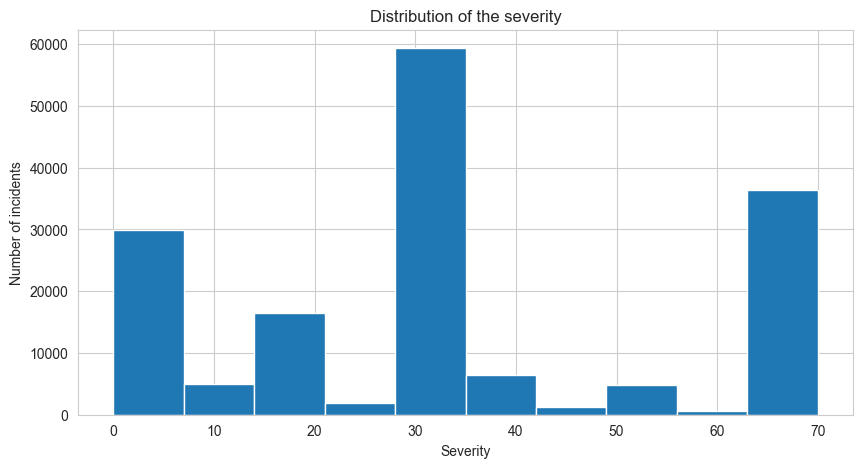

In [60]:
# distribution of the severity
plt.figure(figsize=(10,5))
plt.hist(df_incidents['severity'], bins=10)
plt.xlabel('Severity')
plt.ylabel('Number of incidents')
plt.title('Distribution of the severity')

Text(0.5, 1.0, 'Distribution of the severity')

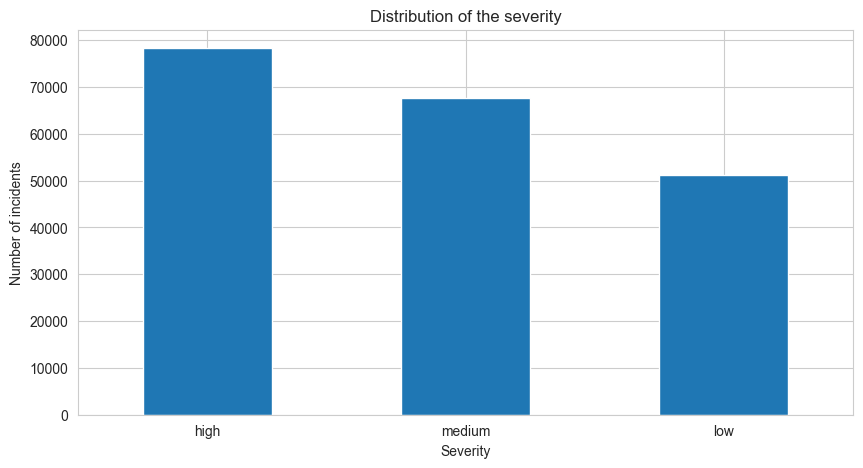

In [65]:
# Let's try to define a new 'severity': we create a categorical feature with values 'low', 'medium', 'high' based on the severity
# Assign low to those with severity <=20, medium to those with severity <=40, high to the others
def f(x):
    if x<=20:
        return 'low'
    elif x<=40:
        return 'medium'
    else:
        return 'high'
df_incidents['severity_cat'] = df_incidents['severity'].apply(f)
# plot the distribution of the severity_cat
plt.figure(figsize=(10,5))
df_incidents['severity_cat'].value_counts().plot(kind='bar')
# make the plot more readable
plt.xticks(rotation=0)
plt.xlabel('Severity')
plt.ylabel('Number of incidents')
plt.title('Distribution of the severity')


In [62]:
# We drop the columns of the ratios
df_incidents.drop(['ratio_killed', 'ratio_injured', 'ratio_unharmed'], axis=1)

,date,state,city_or_county,address,latitude,longitude,congressional_district,avg_age_participants,n_participants_child,n_participants_teen,...,n_unharmed,n_participants,incident_characteristics1,year,povertyPercentage,party,candidatevotes,totalvotes,severity,severity_non_normalized
0,2015-05-02,indiana,Indianapolis,Lafayette Road and Pike Plaza,39.8322,-86.2492,7.0,19.0,0.0,0.0,...,0.0,1.0,Shot - Wounded/Injured,2015.0,12.3,NaN,NaN,NaN,30.0,0.3
1,2017-04-03,pennsylvania,Kane,5647 US 6,41.6645,-78.7856,5.0,62.0,0.0,0.0,...,0.0,1.0,"Shot - Dead (murder, accidental, suicide)",2017.0,10.5,NaN,NaN,NaN,70.0,0.7
2,2016-10-15,district of columbia,Washington,"1000 block of Bladensburg Road, NE",38.9030,-76.9820,1.0,26.0,0.0,0.0,...,0.0,2.0,Shot - Wounded/Injured,2016.0,14.9,NaN,NaN,NaN,30.0,0.3
3,NaT,pennsylvania,Pittsburgh,California and Marshall Avenues,40.4621,-80.0308,14.0,40.0,0.0,0.0,...,1.0,2.0,Shot - Wounded/Injured,NaN,NaN,NaN,NaN,NaN,15.0,0.3
4,2014-01-18,north carolina,Wayne County,4700 block of U.S. Highway 70 East,35.1847,-77.9527,13.0,65.0,0.0,0.0,...,0.0,1.0,Shot - Wounded/Injured,2014.0,15.3,REPUBLICAN,153991.0,268709.0,30.0,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197197,2016-01-11,tennessee,Murfreesboro,Hazelwood Street,35.8624,-86.3695,4.0,23.0,0.0,0.0,...,0.0,1.0,Shot - Wounded/Injured,2016.0,12.6,REPUBLICAN,165796.0,254937.0,30.0,0.3
197198,NaT,new york,Troy,Pawling and Plum Avenues,42.7043,-73.6590,20.0,88.0,0.0,0.0,...,3.0,3.0,Armed robbery with injury/death and/or evidenc...,NaN,NaN,NaN,NaN,NaN,0.0,0.0
197199,2017-08-17,tennessee,Memphis,Barron Ave and Pendleton St,35.1007,-89.9700,9.0,58.0,0.0,0.0,...,0.0,1.0,Shot - Wounded/Injured,2017.0,12.1,NaN,NaN,NaN,30.0,0.3
197200,2016-06-07,colorado,Colorado Springs,601 Prospect Lake Drive,38.8251,-104.8020,5.0,68.0,0.0,0.0,...,1.0,2.0,Non-Shooting Incident,2016.0,8.9,REPUBLICAN,225445.0,361993.0,0.0,0.0


## Children involved

Text(0, 0.5, 'Number of incidents')

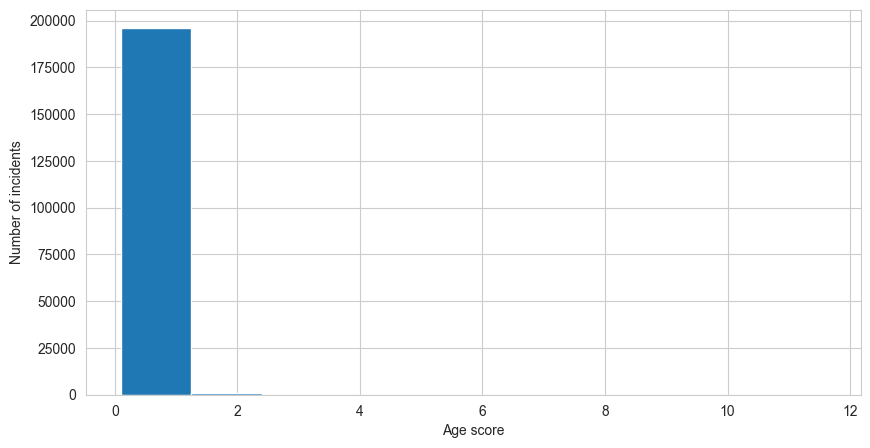

In [72]:
# Now define another severity index based on the age of the participants
# We do it in a categorical fashion as before

total = df_incidents['n_participants_child'] + df_incidents['n_participants_teen'] + df_incidents['n_participants_adult']
df_incidents['ratio_child'] = df_incidents['n_participants_child']
df_incidents['ratio_teen'] = df_incidents['n_participants_teen']
df_incidents['ratio_adult'] = df_incidents['n_participants_adult']

df_incidents['age_score'] = 0.5*df_incidents['ratio_child'] + 0.4*df_incidents['ratio_teen'] + 0.1*df_incidents['ratio_adult']

# histogram of the age_score
plt.figure(figsize=(10,5))
plt.hist(df_incidents['age_score'], bins=10)
plt.xlabel('Age score')
plt.ylabel('Number of incidents')


In [69]:
# show how many incidents with more than 3 children are there
df_incidents[df_incidents['n_participants_teen']>=3].shape

(1213, 34)

### Discretization of ages

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, '[18-24]'),
  Text(1, 0, '[25-34]'),
  Text(2, 0, '[35-44]'),
  Text(3, 0, '[45-54]'),
  Text(4, 0, '[12-17]'),
  Text(5, 0, '[55-64]'),
  Text(6, 0, '[65-74]'),
  Text(7, 0, '[0-11]'),
  Text(8, 0, '[75-100]')])

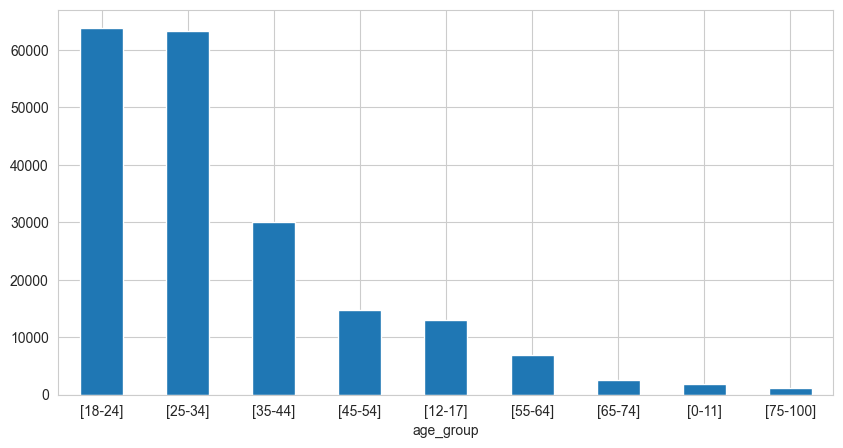

In [70]:
# We want to discretize the feature avg_age_participants in the following classes: [0-11], [12-17], [18-24], [25-34], [35-44], [45-54], [55-64], [65-74], [75-100]
# We create a new feature 'age_group' with the corresponding class
def f(x):
    if x<=11:
        return '[0-11]'
    elif x<=17:
        return '[12-17]'
    elif x<=24:
        return '[18-24]'
    elif x<=34:
        return '[25-34]'
    elif x<=44:
        return '[35-44]'
    elif x<=54:
        return '[45-54]'
    elif x<=64:
        return '[55-64]'
    elif x<=74:
        return '[65-74]'
    else:
        return '[75-100]'
df_incidents['age_group'] = df_incidents['avg_age_participants'].apply(f)
# histogram of the age_group
plt.figure(figsize=(10,5))
df_incidents['age_group'].value_counts().plot(kind='bar')
# make the plot more readable
plt.xticks(rotation=0)

## Injured and killed in a given place and time
We investigate how many injured and killed people have been involved w.r.t the total injured and
killed people in the same congressional district in a month

In [150]:
df_incidents.date=pd.to_datetime(df_incidents.date)

In [151]:
#- raggruppare in base al mese, congressional district, stato
#- injured / tot. injured , killed / tot. killed in congr. and month

df_incidents['year_month'] = df_incidents.date.dt.strftime('%y-%m')
df_incidents.year_month.isnull().sum()

tot_killed = df_incidents.groupby(['state', 'congressional_district', 'year_month'])['n_killed'].sum()
# Convert the Series to a DataFrame and reset the index
tot_killed_df = tot_killed.reset_index()

# Rename the 'n_killed' column to a desired name
tot_killed_df = tot_killed_df.rename(columns={'n_killed': 'total_killed'})

# Print the resulting DataFrame
print(tot_killed_df)


#Same for the injured
tot_injured = df_incidents.groupby(['state', 'congressional_district', 'year_month'])['n_injured'].sum()
# Convert the Series to a DataFrame and reset the index
tot_injured_df = tot_injured.reset_index()

# Rename the 'n_killed' column to a desired name
tot_injured_df = tot_injured_df.rename(columns={'n_injured': 'total_injured'})

         state  congressional_district year_month  total_killed
0      alabama                     1.0      14-01             3
1      alabama                     1.0      14-02             5
2      alabama                     1.0      14-03             3
3      alabama                     1.0      14-04             3
4      alabama                     1.0      14-05             7
...        ...                     ...        ...           ...
21112  wyoming                     1.0      17-05             0
21113  wyoming                     1.0      17-06             0
21114  wyoming                     1.0      17-07             0
21115  wyoming                     1.0      17-08             3
21116  wyoming                     1.0      17-09             1

[21117 rows x 4 columns]


In [153]:
# We join the 'total_killed' and 'total_injured' columns to the incidents dataset
df_incidents =pd.merge( df_incidents, tot_killed_df, on=['state', 'congressional_district', 'year_month'])

In [154]:
df_incidents = pd.merge(df_incidents, tot_injured_df, on=['state', 'congressional_district', 'year_month'])
df_incidents.head()

,date,state,city_or_county,address,latitude,longitude,congressional_district,avg_age_participants,n_participants_child,n_participants_teen,...,candidatevotes,totalvotes,ratio_killed,ratio_injured,ratio_unharmed,severity,severity_non_normalized,year_month,total_killed,total_injured
0,2015-05-02,indiana,Indianapolis,Lafayette Road and Pike Plaza,39.8322,-86.2492,7.0,19.0,0.0,0.0,...,NaN,NaN,0.0,100.0,0.0,30.0,0.3,15-05,3,4
1,2015-05-03,indiana,Indianapolis,502 N. Rural Street,39.7745,-86.1166,7.0,32.0,0.0,0.0,...,NaN,NaN,100.0,0.0,0.0,60.0,0.6,15-05,3,4
2,2015-05-25,indiana,Indianapolis,800 block of Chapelwood Boulevard,39.7759,-86.2940,7.0,36.0,0.0,0.0,...,NaN,NaN,100.0,0.0,0.0,60.0,0.6,15-05,3,4
3,2015-05-03,indiana,Indianapolis,East 25th Street and North Post Road,39.8040,-86.0095,7.0,18.0,0.0,0.0,...,NaN,NaN,100.0,0.0,0.0,60.0,0.6,15-05,3,4
4,2015-05-30,indiana,Indianapolis,3018 West 16th Street,39.7882,-86.2091,7.0,53.0,0.0,0.0,...,NaN,NaN,0.0,100.0,0.0,30.0,0.3,15-05,3,4


In [155]:
# We distinguish between the case with total_killed = 0, and total_killed != 0

def f(x, y):
    if y!=0:
        return x/y
    else:
        return 0
df_incidents['killed_by_district'] = df_incidents.apply(lambda row: f(row['n_killed'], row['total_killed']), axis=1)

df_incidents['injured_by_district'] = df_incidents.apply(lambda row: f(row['n_injured'], row['total_injured']), axis=1)

(array([ 9667., 11578.,  5210.,  6484.,  6517.,    92.,   698.,   141.,
           16.,  5894.]),
 array([0.01639344, 0.1147541 , 0.21311475, 0.31147541, 0.40983607,
        0.50819672, 0.60655738, 0.70491803, 0.80327869, 0.90163934,
        1.        ]),
 <BarContainer object of 10 artists>)

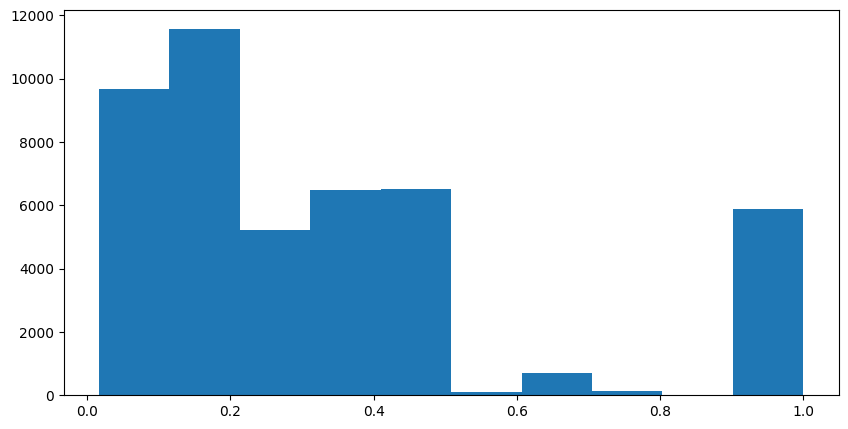

In [156]:
# Let's see the distribution of the feature 'killed_by_district'
plt.figure(figsize=(10, 5))
plt.hist(df_incidents.killed_by_district[df_incidents['killed_by_district']!=0], bins=10)

(array([135404.,  16050.,   6892.,    918.,   5243.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 <BarContainer object of 5 artists>)

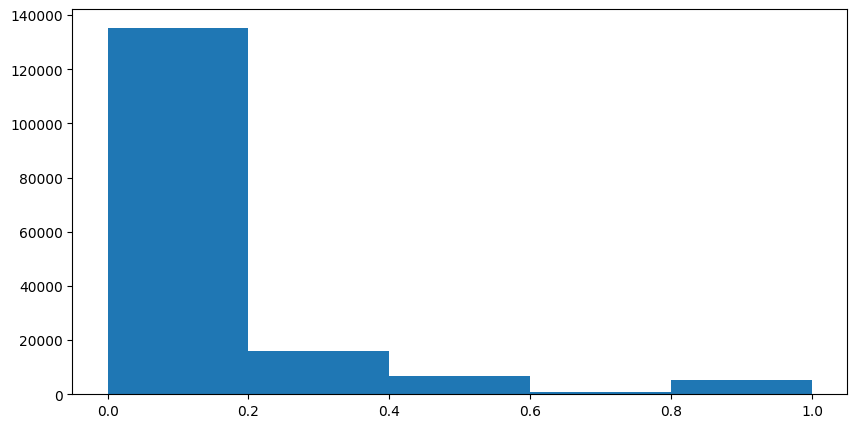

In [157]:
plt.figure(figsize=(10, 5))
plt.hist(df_incidents['injured_by_district'], bins=5)

# Aggregated dataset

We group the incidents that happened in the same congressional district of each state: label [state, congressional district] (and eventually in the same year, month).

We consider the numerical features of the dataset df_incidents:
- the mean of 'avg_age_participants'
- the sum of the features 'n_participants_child'-'n_participants'

We also add the 'povertyPercentage' feature of df_poverty for each state, year.

Finally, given the year of the incident, we add the 'party', 'candidatevotes', 'totalvotes' features from the dataset df_elections for each [state, congressional district].

In [158]:
#TODO : age groups
#TODO : severity index based on age/age group with children or teens involved being more severe
#TODO: ratio candidatevotes/totalvotes
